## Initialize

In [1]:
%matplotlib inline

import pickle, os, sys

import numpy as np
import random

from librosa import zero_crossings, power_to_db
from librosa.feature import melspectrogram, mfcc

from deap import creator, gp, base, tools
import librosa

import yaml

import matplotlib.pyplot as plt
import pygraphviz as pgv
plt.ion()

from ipywidgets import interactive, interact
import ipywidgets as widgets
import IPython.display as ip_disp
from  IPython.display import HTML

# Necessary to be able to import code from the main Python files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gensynth.supercollider.representation import get_primitive_set, available_ugens
from gensynth.supercollider.synthesis import initialize_synthesis_dirs
from gensynth.supercollider.fitness import reevaluate_individuals

initialize_synthesis_dirs()

In [2]:
primitive_set = get_primitive_set()

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=primitive_set)

toolbox = base.Toolbox()
toolbox.register(
    "generateSynthTree",
    gp.genGrow,
    pset=primitive_set,
    min_=1,
    max_=3
)

# Create an individual generating function that is a synth definition tree
toolbox.register("individual", tools.initIterate, container=creator.Individual, generator=toolbox.generateSynthTree)

# Create a population function that generates a list of n individuals using the individual() function.
toolbox.register("population", tools.initRepeat, container=list, func=toolbox.individual)

In [3]:
# Workaround for being able to generate synth sounds from within Jupyter
import nest_asyncio
nest_asyncio.apply()

## Define Label

In [4]:
label_audio_name = "synthetic/multiple_oscillations"
sample_rate = 44100
duration = 0.1

label_audio_path = "../sounds/" + label_audio_name + ".aiff"
label_audio, _ = librosa.load(label_audio_path, sr=sample_rate)

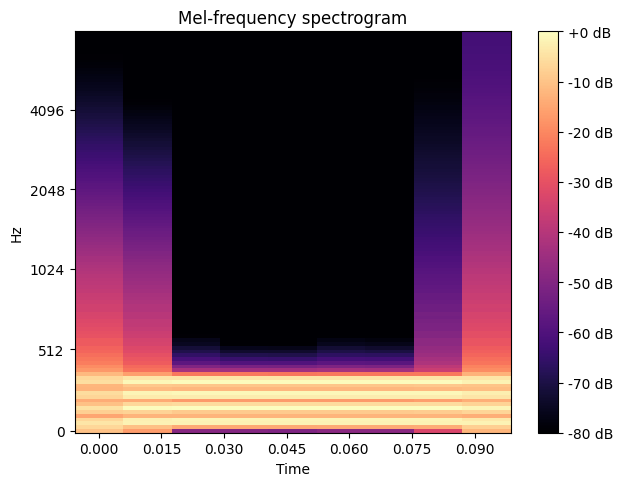

In [5]:
audio_widget = ip_disp.Audio(
    data=label_audio, 
    rate=sample_rate
)
display(audio_widget)

mel_spectrogram_label = librosa.feature.melspectrogram(y=label_audio, sr=sample_rate)
mel_spectrogram_decibel_label = librosa.power_to_db(mel_spectrogram_label, ref=np.max)
figure, ax = plt.subplots()
img = librosa.display.specshow(
    mel_spectrogram_decibel_label,
    x_axis='time',
    y_axis='mel',
    sr=sample_rate,
    fmax=8000,
    ax=ax
)
figure.colorbar(img, ax=ax, format='%+2.0f dB')
plt.tight_layout()
ax.set(title='Mel-frequency spectrogram')
plt.show()

## Generate test cases

In [6]:
individual_count = 7
individuals = toolbox.population(n=individual_count)

In [7]:
reevaluate_individuals(individuals, label_audio, primitive_set, duration, sample_rate, fitness_function="mel_db", helper_objective="mfcc", sc_executable_path="../SuperCollider/installation/bin/scsynth")

-- Generating Audio
-- Computing Losses


In [8]:
def display_solutions(individuals, extra=None):
    solution_widgets = []
    for index, individual in enumerate(individuals):
        solution_widget = widgets.Output()
        with solution_widget:
            audio_widget = ip_disp.Audio(
                data=individual.audio, 
                rate=sample_rate
            )
            display(audio_widget)
            
            mel_spectrogram = librosa.feature.melspectrogram(y=individual.audio, sr=sample_rate)
            mel_spectrogram_decibel = librosa.power_to_db(mel_spectrogram, ref=np.max)
            figure, ax = plt.subplots()
            img = librosa.display.specshow(
                mel_spectrogram_decibel,
                x_axis='time',
                y_axis='mel',
                sr=sample_rate,
                fmax=8000,
                ax=ax
            )
            figure.colorbar(img, ax=ax, format='%+2.0f dB')
            plt.tight_layout()
            ax.set(title='Mel-frequency spectrogram')
            plt.show()

            if extra is not None:
                display(extra[index])
            
            #display(str(individual))
            
        solution_widgets.append(solution_widget)
    
    all_solutions = widgets.HBox(solution_widgets)
    display(all_solutions)

In [9]:
display_solutions(individuals)

### Analyze Losses

#### Mel DB

In [10]:
def mel_db_loss(individual):
    label_spectrogram = melspectrogram(y=label_audio, sr=sample_rate)
    output_spectrogram = melspectrogram(y=individual.audio, sr=sample_rate)

    label_spectrogram = power_to_db(label_spectrogram, ref=np.max)
    output_spectrogram = power_to_db(output_spectrogram, ref=np.max)

    difference = label_spectrogram - output_spectrogram


    distance_l1 = np.linalg.norm(
        difference,
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=1
    )

    distance_l2 = np.linalg.norm(
        difference.astype(float),
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=2
    )

    # Sum over all time steps
    total = np.sum(
        distance_l1 + distance_l2,
        axis=(0,)
    )

    return total

for individual in individuals:
    individual.mel_db_loss = mel_db_loss(individual)

sorted_individuals = sorted(individuals, key=mel_db_loss)
display_solutions(sorted_individuals, extra=[individual.mel_db_loss for individual in sorted_individuals])

### Mel DB L1

In [11]:
def mel_db_l1_loss(individual):
    label_spectrogram = melspectrogram(y=label_audio, sr=sample_rate)
    output_spectrogram = melspectrogram(y=individual.audio, sr=sample_rate)

    label_spectrogram = power_to_db(label_spectrogram, ref=np.max)
    output_spectrogram = power_to_db(output_spectrogram, ref=np.max)

    difference = label_spectrogram - output_spectrogram

    distance_l1 = np.linalg.norm(
        difference,
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=1
    )
    
    # Sum over all time steps
    total = np.sum(
        distance_l1,
        axis=(0,)
    )

    return total

for individual in individuals:
    individual.mel_db_l1_loss = mel_db_l1_loss(individual)

sorted_individuals = sorted(individuals, key=mel_db_l1_loss)
display_solutions(sorted_individuals, extra=[individual.mel_db_l1_loss for individual in sorted_individuals])

### Mel DB L2

In [12]:
def mel_db_l2_loss(individual):
    label_spectrogram = melspectrogram(y=label_audio, sr=sample_rate)
    output_spectrogram = melspectrogram(y=individual.audio, sr=sample_rate)

    label_spectrogram = power_to_db(label_spectrogram, ref=np.max)
    output_spectrogram = power_to_db(output_spectrogram, ref=np.max)

    difference = label_spectrogram - output_spectrogram

    distance_l2 = np.linalg.norm(
        difference,
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=2
    )
    
    # Sum over all time steps
    total = np.sum(
        distance_l2,
        axis=(0,)
    )

    return total

for individual in individuals:
    individual.mel_db_l2_loss = mel_db_l2_loss(individual)

sorted_individuals = sorted(individuals, key=mel_db_l2_loss)
display_solutions(sorted_individuals, extra=[individual.mel_db_l2_loss for individual in sorted_individuals])

### MFCC

In [13]:
def mfcc_loss(individual):
    label_spectrogram = mfcc(y=label_audio, sr=sample_rate)
    output_spectrogram = mfcc(y=individual.audio, sr=sample_rate)

    label_spectrogram = power_to_db(label_spectrogram, ref=np.max)
    output_spectrogram = power_to_db(output_spectrogram, ref=np.max)

    difference = label_spectrogram - output_spectrogram


    distance_l1 = np.linalg.norm(
        difference,
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=1
    )

    distance_l2 = np.linalg.norm(
        difference.astype(float),
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=2
    )

    # Sum over all time steps
    total = np.sum(
        distance_l1 + distance_l2,
        axis=(0,)
    )

    return total

for individual in individuals:
    individual.mfcc_loss = mfcc_loss(individual)

sorted_individuals = sorted(individuals, key=mfcc_loss)
display_solutions(sorted_individuals, extra=[individual.mfcc_loss for individual in sorted_individuals])

### MFCC L1

In [14]:
def mfcc_l1_loss(individual):
    label_spectrogram = mfcc(y=label_audio, sr=sample_rate)
    output_spectrogram = mfcc(y=individual.audio, sr=sample_rate)

    label_spectrogram = power_to_db(label_spectrogram, ref=np.max)
    output_spectrogram = power_to_db(output_spectrogram, ref=np.max)

    difference = label_spectrogram - output_spectrogram


    distance_l1 = np.linalg.norm(
        difference,
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=1
    )

    # Sum over all time steps
    total = np.sum(
        distance_l1,
        axis=(0,)
    )

    return total

for individual in individuals:
    individual.mfcc_l1_loss = mfcc_l1_loss(individual)

sorted_individuals = sorted(individuals, key=mfcc_l1_loss)
display_solutions(sorted_individuals, extra=[individual.mfcc_l1_loss for individual in sorted_individuals])

### MFCC L2

In [15]:
def mfcc_l2_loss(individual):
    label_spectrogram = mfcc(y=label_audio, sr=sample_rate)
    output_spectrogram = mfcc(y=individual.audio, sr=sample_rate)

    label_spectrogram = power_to_db(label_spectrogram, ref=np.max)
    output_spectrogram = power_to_db(output_spectrogram, ref=np.max)

    difference = label_spectrogram - output_spectrogram

    distance_l2 = np.linalg.norm(
        difference.astype(float),
        # The last axis is omitted to compute the norm for each time step separately
        axis=(0,),
        ord=2
    )

    # Sum over all time steps
    total = np.sum(
        distance_l2,
        axis=(0,)
    )

    return total

for individual in individuals:
    individual.mfcc_l2_loss = mfcc_l2_loss(individual)

sorted_individuals = sorted(individuals, key=mfcc_l2_loss)
display_solutions(sorted_individuals, extra=[individual.mfcc_l2_loss for individual in sorted_individuals])

### Zero Crossings

In [16]:
def zero_crossings_loss(individual):
    # Output: Array of booleans indicating whether zero was crossed at a particular sample or not
    label_zero_crossings = zero_crossings(label_audio)
    output_zero_crossings = zero_crossings(individual.audio, axis=-1)

    # Counting the indices where the boolean values differ.
    difference = np.logical_xor(label_zero_crossings, output_zero_crossings)

    total = np.sum(
        difference,
        axis=(0,)
    )

    return total

for individual in individuals:
    individual.zero_crossings_loss = zero_crossings_loss(individual)

sorted_individuals = sorted(individuals, key=zero_crossings_loss)
display_solutions(sorted_individuals, extra=[individual.zero_crossings_loss for individual in sorted_individuals])

ValueError: operands could not be broadcast together with shapes (4416,) (4410,) 

## Findings

- The Mel fitness is dominated by the L1 part, which prefers silence to the other options. The L2 part creates a better ranking.
- The MFCC fitness is dominated by the L1 part as well, but L1 and L2 parts agree. MFCC prefers a more interesting solution, but most prefers silence. The intuitively best solution isn't ranked very highly.
- Zero Crossings prefers silence over any signal. The signals are at least in the right order, but this is still not great.

- In one case, MFCC selected the intuitively best solution as the correct one.
- A silence part preferred by Mel was correctly discarded by ZC and MFCC

- A good candidate was correctly selected by MFCC, discared for silence by ZC and ranked too low by Mel (notably still better by L2 than L1)
- Seems like L1 can generally be discarded.

- A very large number of initial individuals contains either silence or uninteresting noise.

- MFCC scores another time of being the only one to select a valuable solution. (+1)

Conclusions:
- L1 needs to go.
- MFCC should probably be the main fitness
- Maybe we can use Mel L2 and ZC as secondary fitnesses?
- The base material doesn't seem to be very good to work with. Maybe we really need larger starting blocks?